In [90]:
import logging
from typing import Any, Callable, List, Literal, Type, Dict, Union
from pathlib import Path
import argparse
import glob
import pickle
import os
import json
import mteb

import numpy as np
import torch
import mteb

from utils.misc.model_dataloader_utils import get_model_path, model_name_to_sizes
from utils.model_definitions.mteb_automodel_wrapper import AutoModelWrapper, ModelSpecifications

In [91]:
def handle_special_mteb_results(data):
    special_benchmarks = ['STS17', 'AmazonCounterfactualClassification']

    if data.get('task_name') not in special_benchmarks:
        assert len(data.get('scores').get('test')) == 1, \
            f"Expected 1 score for {data.get('task_name')}, got {len(data.get('scores').get('test'))}"
        
        return data.get('scores').get('test')[0].get('main_score')
    
    if data.get('task_name') == 'STS17':
        scores = data.get('scores', {}).get('test', [])
        filtered_scores = [
            score for score in scores 
            if score.get('languages') == ['eng-Latn']
        ]
        assert len(filtered_scores) == 1
        return filtered_scores[0].get('main_score')

    elif data.get('task_name') == 'AmazonCounterfactualClassification':
        scores = data.get('scores', {}).get('test', [])
        filtered_scores = [
            score for score in scores 
            if score.get('hf_subset') in ['en', 'en-ext']
        ]
        assert len(filtered_scores) == 2

        english_score = filtered_scores[0].get('main_score')
        english_ext_score = filtered_scores[1].get('main_score') # harder superset, described in Sec 3.3 of https://aclanthology.org/2021.emnlp-main.568.pdf

        return (english_score + english_ext_score) / 2
    else:
        raise ValueError(f"Special benchmark handling for {data.get('task_name')} not found")
    
def get_task_type_from_task_name(task_name: str):
    mteb_task = mteb.get_task(task_name)
    return mteb_task.metadata.type
        
def load_layerwise_results_for_specific_model(model_specs: ModelSpecifications, dataloader_kwargs):
    model_family = model_specs.model_family
    model_size = model_specs.model_size
    revision = model_specs.revision
    dataset = dataloader_kwargs['dataset_name']

    results = {}
    results['metrics'] = {}
    wikitext_load_dir = f"results/{model_family}/{model_size}/{revision}/metrics/{dataset}/"
    for file_path in glob.glob(f"{wikitext_load_dir}/*.pkl"):
        with open(file_path, "rb") as f:
            key = os.path.basename(file_path)[:-4]
            results['metrics'][key] = pickle.load(f)
    
    mteb_load_dir = f"results/{model_family}/{model_size}/{revision}/mteb/"
    results['mteb'] = {}
    for layer_dir in glob.glob(f"{mteb_load_dir}/layer_*"):
        for json_file in glob.glob(f"{layer_dir}/*.json"):
            dataset_name = os.path.basename(json_file)[:-5]
            
            if dataset_name == 'model_meta':
                continue

            if dataset_name not in results['mteb']:
                results['mteb'][dataset_name] = {}
                results['mteb'][dataset_name]['scores'] = []
                results['mteb'][dataset_name]['time_elapsed'] = []
            with open(json_file, 'r') as f:
                data = json.load(f)
                main_score = handle_special_mteb_results(data)
                results['mteb'][dataset_name]['scores'].append(main_score)

                time_elapsed = data.get('evaluation_time', None)
                results['mteb'][dataset_name]['time_elapsed'].append(time_elapsed)
                
                if 'task_type' not in results['mteb'][dataset_name]:
                    results['mteb'][dataset_name]['task_type'] = get_task_type_from_task_name(dataset_name)
    return results

In [92]:
model_family = 'mamba'
model_size = '130m'
revision = 'main'

model_specs = ModelSpecifications(model_family, model_size, revision=revision)
results = load_layerwise_results_for_specific_model(model_specs, {'dataset_name': 'wikitext'})

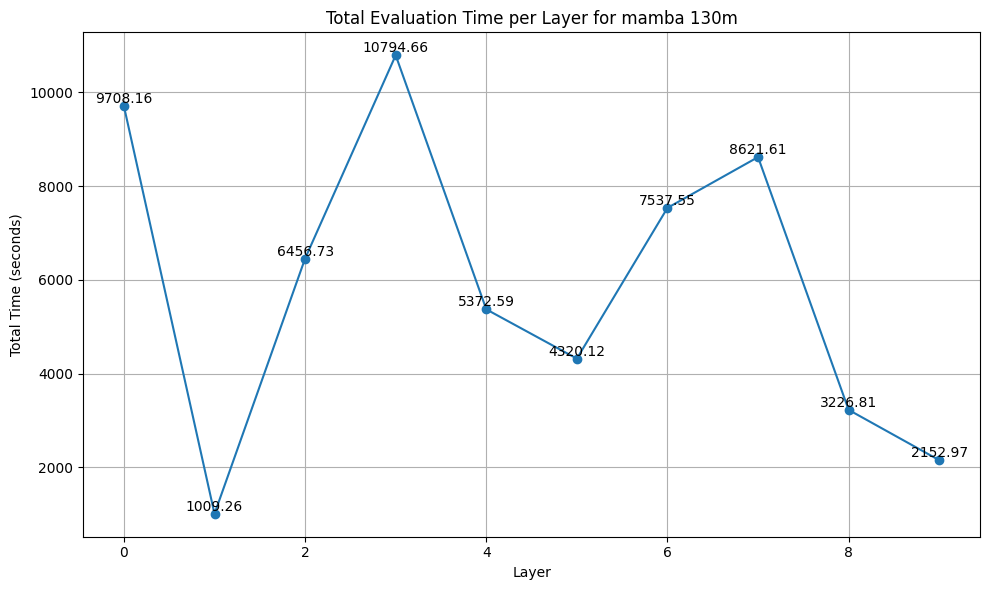

{0: 9708.155741930008, 1: 1009.2646534442902, 2: 6456.726642608643, 3: 10794.656091213226, 4: 5372.590310335159, 5: 4320.123330831528, 6: 7537.551781177521, 7: 8621.609997987747, 8: 3226.809100627899, 9: 2152.9721829891205}


In [82]:
import matplotlib.pyplot as plt

total_time_elapsed_per_layer = {}
for dataset, data in results['mteb'].items():
    for layer, time in enumerate(data['time_elapsed']):
        if layer not in total_time_elapsed_per_layer:
            total_time_elapsed_per_layer[layer] = 0
        if time is not None:
            total_time_elapsed_per_layer[layer] += time

# Sort the dictionary by layer number
sorted_times = sorted(total_time_elapsed_per_layer.items())

# Separate layers and times for plotting
layers, times = zip(*sorted_times)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(layers, times, marker='o')
plt.title(f'Total Evaluation Time per Layer for {model_family} {model_size}')
plt.xlabel('Layer')
plt.ylabel('Total Time (seconds)')
plt.grid(True)

# Add text labels for each point
for layer, time in sorted_times:
    plt.text(layer, time, f'{time:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(total_time_elapsed_per_layer)


# plotting

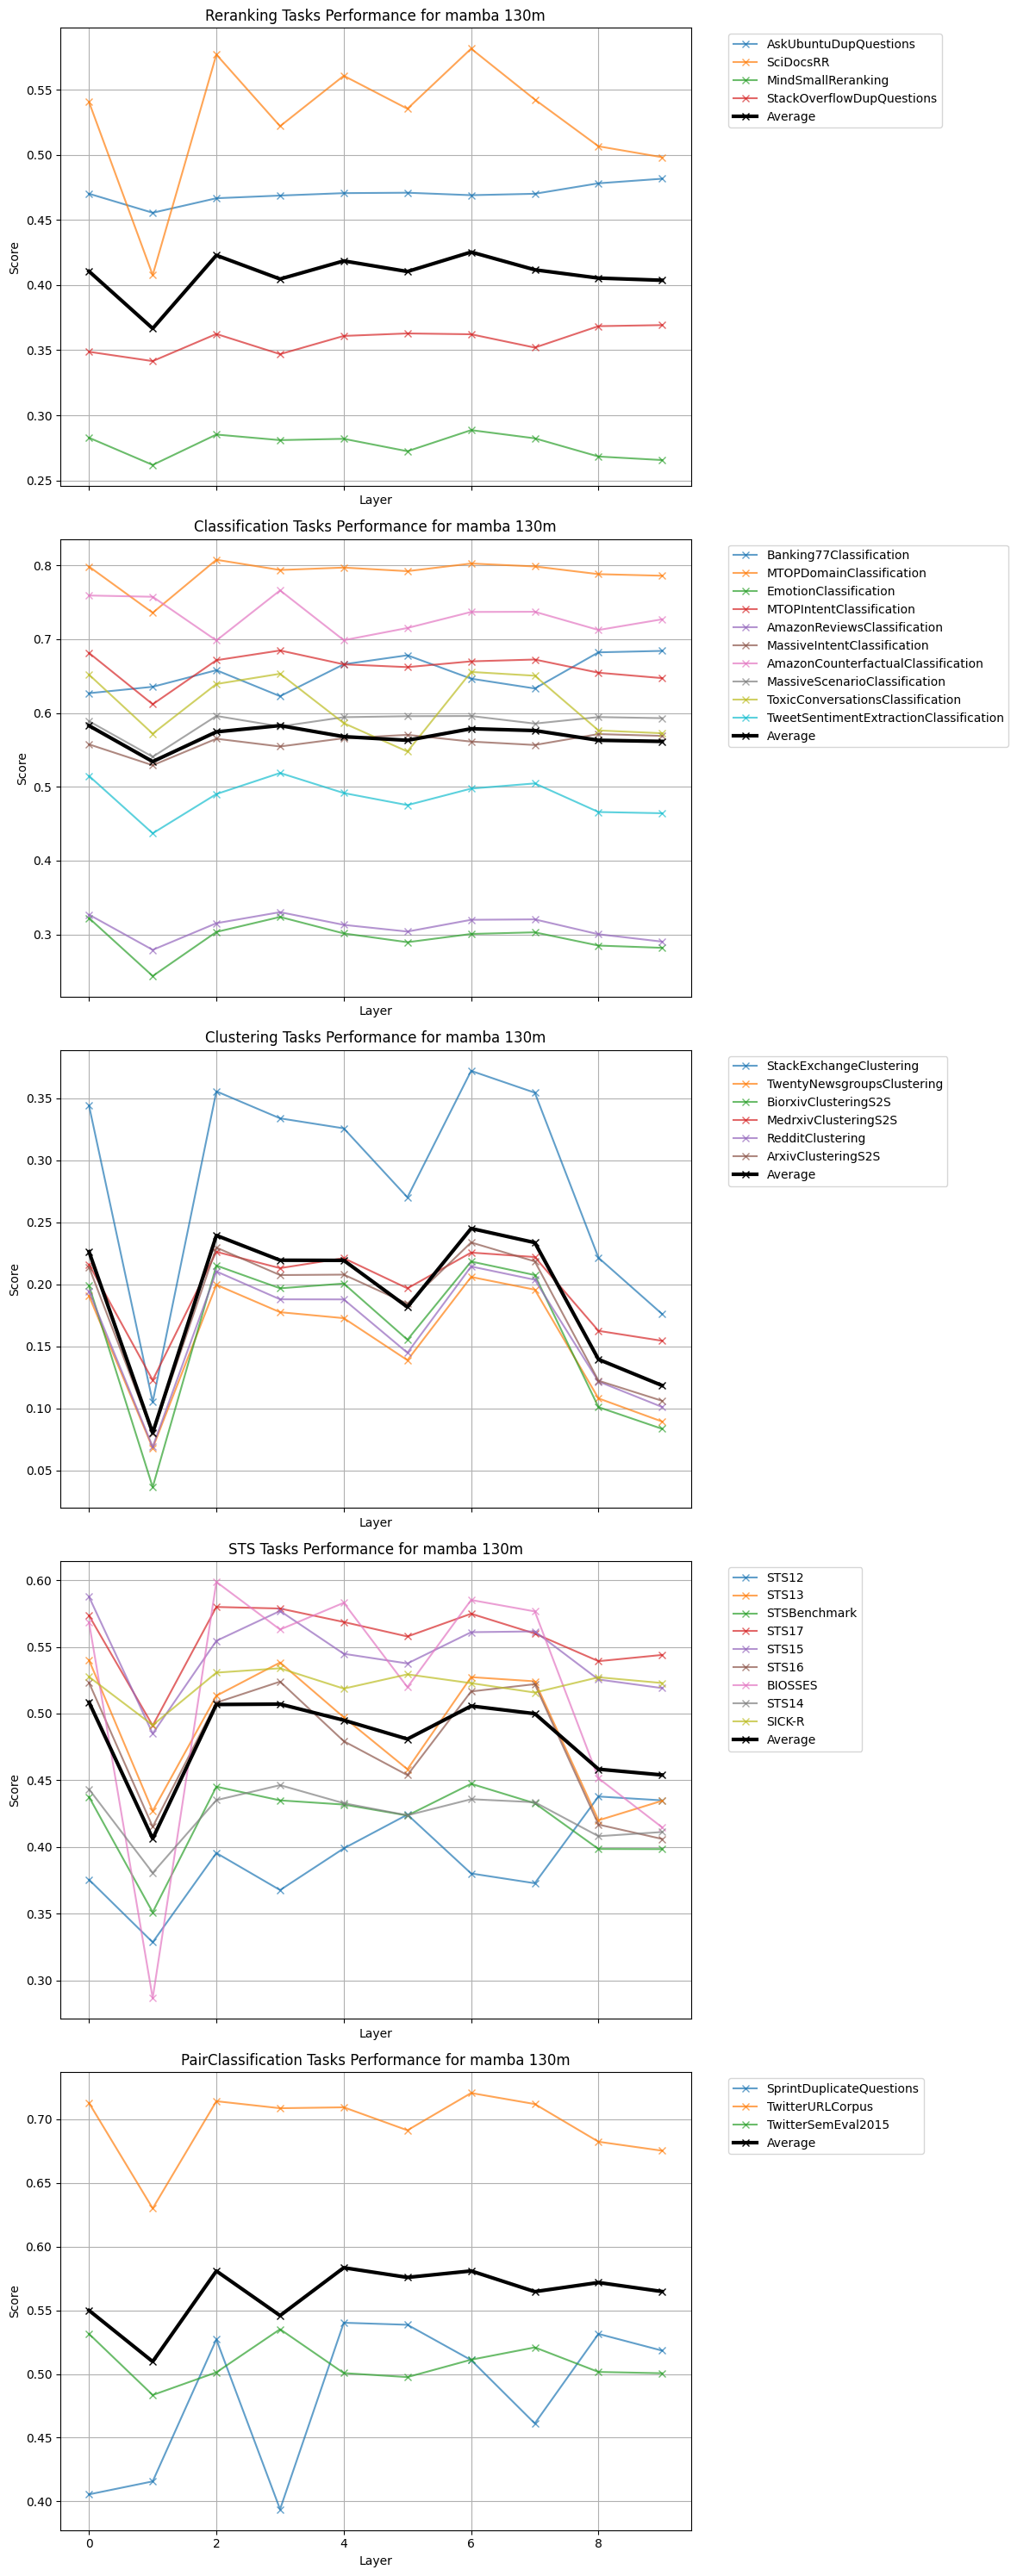

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Group tasks by task type
task_types = {}
for task, data in results['mteb'].items():
    task_type = data['task_type']
    if task_type not in task_types:
        task_types[task_type] = {}
    task_types[task_type][task] = data

# Create subplots
num_task_types = len(task_types)
fig, axs = plt.subplots(num_task_types, 1, figsize=(12, 6*num_task_types), sharex=True)

for i, (task_type, tasks) in enumerate(task_types.items()):
    ax = axs[i] if num_task_types > 1 else axs
    all_scores = []
    
    for task, data in tasks.items():
        scores = data['scores']
        layers = range(len(scores))
        ax.plot(layers, scores, label=task, alpha=0.7, marker='x')
        all_scores.append(scores)
    
    # Calculate and plot the average line
    if all_scores:
        average_scores = np.mean(all_scores, axis=0)
        ax.plot(layers, average_scores, label='Average', linewidth=3, color='black', marker='x')
    
    ax.set_xlabel('Layer')
    ax.set_ylabel('Score')
    ax.set_title(f'{task_type} Tasks Performance for {model_family} {model_size}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


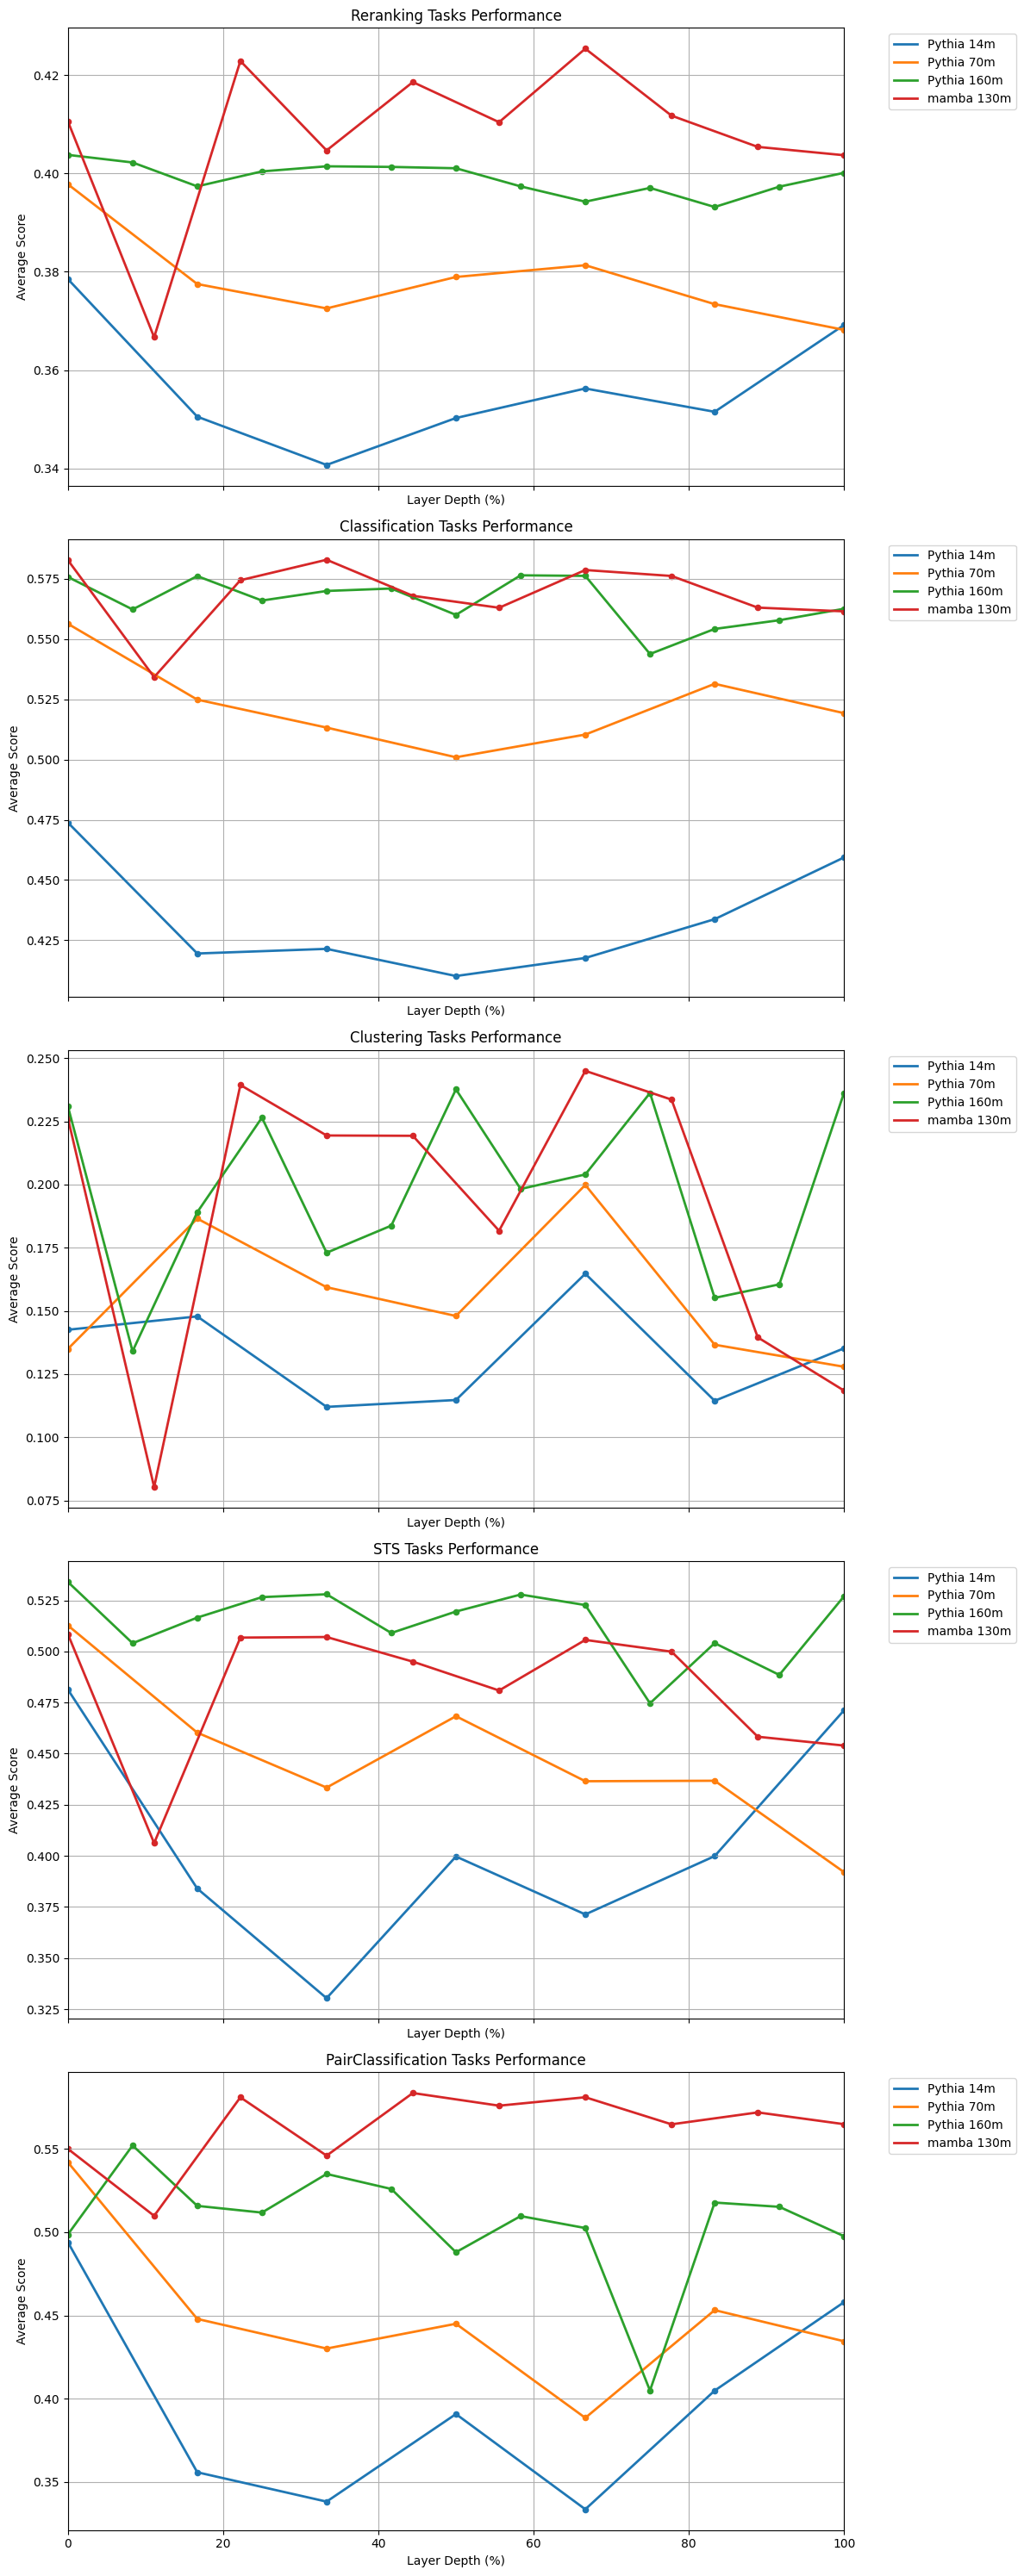

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Define model families and sizes
model_families = ['Pythia', 'mamba']  # Add or modify as needed
model_sizes = {
    'Pythia': ['14m', '70m', '160m'],
    'mamba': ['130m']
}

results = {}

# Load results for each model family and size
for family in model_families:
    results[family] = {}
    for size in model_sizes[family]:
        results[family][size] = load_layerwise_results_for_specific_model(ModelSpecifications(family, size, revision=revision), {'dataset_name': 'wikitext'})

# Group tasks by task type
task_types = {}
for family in model_families:
    for size in model_sizes[family]:
        for task, data in results[family][size]['mteb'].items():
            task_type = data['task_type']
            if task_type not in task_types:
                task_types[task_type] = {}
            if task not in task_types[task_type]:
                task_types[task_type][task] = {}
            if family not in task_types[task_type][task]:
                task_types[task_type][task][family] = {}
            task_types[task_type][task][family][size] = data

# Create subplots
num_task_types = len(task_types)
fig, axs = plt.subplots(num_task_types, 1, figsize=(12, 6*num_task_types), sharex=True)

for i, (task_type, tasks) in enumerate(task_types.items()):
    ax = axs[i] if num_task_types > 1 else axs
    
    for family in model_families:
        for size in model_sizes[family]:
            all_scores = []
            max_layers = 0
            for task, family_data in tasks.items():
                if family in family_data and size in family_data[family]:
                    scores = family_data[family][size]['scores']
                    max_layers = max(max_layers, len(scores))
                    all_scores.append(scores)
            
            # Calculate and plot the average line and points for each size
            if all_scores:
                average_scores = np.mean(all_scores, axis=0)
                layers_percentage = np.linspace(0, 100, len(average_scores))
                ax.plot(layers_percentage, average_scores, linewidth=2, label=f'{family} {size}')
                ax.scatter(layers_percentage, average_scores, s=20)
    
    ax.set_xlabel('Layer Depth (%)')
    ax.set_ylabel('Average Score')
    ax.set_title(f'{task_type} Tasks Performance')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()


In [ ]:
layer_entropy = results['metrics']['layer_entropy']['maxEntropy']
